## Vision Transformer (ViT) Fine-Tuning on Modified Mini-GCD Dataset for Cloud Image Classification

### 0. Setup Environment

#### 0.1 Imports

In [1]:
import torch
import os
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder
from transformers import ViTForImageClassification, ViTFeatureExtractor
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import random
from torch.optim.lr_scheduler import ReduceLROnPlateau

#### 0.2 Checking for GPU availability

In [2]:
print(torch.cuda.is_available())
print(torch.cuda.get_device_name())
print(torch.cuda.device_count())
print(torch.cuda.current_device())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

True
NVIDIA GeForce RTX 3050 Ti Laptop GPU
1
0
cuda


#### 0.3 Setting hyperparams

In [3]:
data_dirs = [ "mini-GCD-modified", "GCD-modified"]
selected_dir = data_dirs[0]

#### 1. Load Modified Mini-GCD Dataset

In [14]:
# Define transformations with data augmentation
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

transform_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

# Load Dataset
train_dir = os.path.join(selected_dir, "train")
val_dir = os.path.join(selected_dir, "val")
test_dir = os.path.join(selected_dir, "test")

train_dataset = ImageFolder(root=train_dir, transform=transform_train)
val_dataset = ImageFolder(root=val_dir, transform=transform_val)
test_dataset = ImageFolder(root=test_dir, transform=transform_val)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# Class Names
class_names = train_dataset.classes
print(f"Classes: {class_names}")

# Show number of training samples per class
train_class_counts = {class_names[i]: 0 for i in range(len(class_names))}
for _, label in train_dataset:
    train_class_counts[class_names[label]] += 1
print("Train Class Counts:", train_class_counts)

# Display the number of training samples
print(f"Total number of training samples: {len(train_dataset)}")

Classes: ['1_cumulus', '4_clearsky', '6_cumulonimbus']
Train Class Counts: {'1_cumulus': 4, '4_clearsky': 4, '6_cumulonimbus': 4}
Total number of training samples: 12


#### 1.1. Display Sample Images

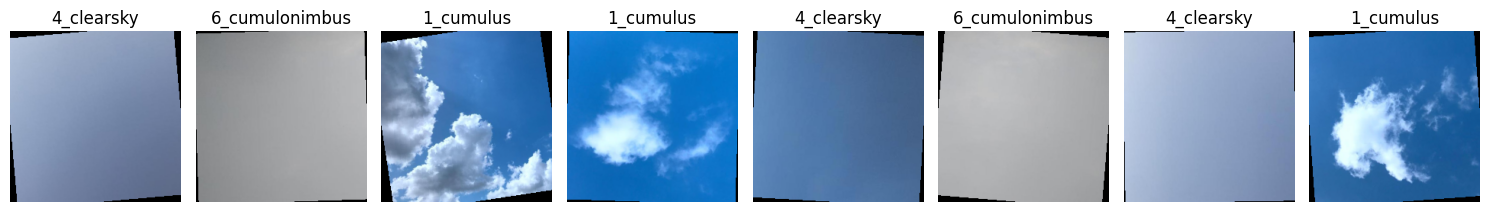

In [5]:
# Display Sample Images
def show_images(dataloader, class_names):
    images, labels = next(iter(dataloader))
    fig, axes = plt.subplots(1, len(images), figsize=(15, 5))
    for idx, ax in enumerate(axes):
        img = images[idx].permute(1, 2, 0).numpy()
        img = (img * 0.5 + 0.5)  # Unnormalize
        img = np.clip(img, 0, 1)
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(class_names[labels[idx]])
    plt.tight_layout()
    plt.show()

show_images(train_loader, class_names)

#### 2. Load ViT Feature Extractor (Pretrained)

In [6]:
# Load ViT Feature Extractor (Pretrained)
from transformers import ViTModel, ViTForImageClassification, ViTFeatureExtractor

# Instantiate ViT feature extractor
feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224-in21k")
vit_model = ViTModel.from_pretrained("google/vit-base-patch16-224-in21k")

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

C:\global_envs\pytorch_env\Lib\site-packages\huggingface_hub\file_download.py:139: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Stefan\.cache\huggingface\hub\models--google--vit-base-patch16-224-in21k. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
C:\global_envs\pytorch_env\Lib\site-packages\transformers\models\vit\feature_extraction_vit.py:28: FutureWa

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

#### 2.1. Setup Diffusion-based Image Classifier with ViT Feature Extractor

In [7]:
# Define the ViTClassifier with ViT feature extractor
class ViTClassifier(nn.Module):
    def __init__(self, vit_model, num_classes):
        super(ViTClassifier, self).__init__()
        self.vit_model = vit_model
        self.fc = nn.Linear(vit_model.config.hidden_size, num_classes)  # Hidden size of ViT model
        self.dropout = nn.Dropout(0.5)  # Add dropout for regularization

    def forward(self, x):
        features = self.vit_model(x).last_hidden_state.mean(dim=1)  # Use mean of sequence (CLS token)
        features = self.dropout(features)  # Apply dropout
        out = self.fc(features)
        return out

def count_trainable_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Instantiate classifier with ViT feature extractor
num_classes = len(class_names)
classifier = ViTClassifier(vit_model, num_classes).to(device)
print(f"Trainable Parameters: {count_trainable_params(classifier):,}")

# Define Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(classifier.parameters(), lr=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

Trainable Parameters: 86,391,555


#### 3. Train the model

Epoch 1/30, Train Loss: 0.6565, Val Loss: 0.4397
Epoch 2/30, Train Loss: 0.1149, Val Loss: 0.4972
Epoch 3/30, Train Loss: 0.0518, Val Loss: 0.5822
Epoch 4/30, Train Loss: 0.0378, Val Loss: 0.6330
Epoch 5/30, Train Loss: 0.0297, Val Loss: 0.6596
Epoch 6/30, Train Loss: 0.0262, Val Loss: 0.7041
Epoch 7/30, Train Loss: 0.0235, Val Loss: 0.7424
Epoch 8/30, Train Loss: 0.0210, Val Loss: 0.7625
Epoch 9/30, Train Loss: 0.0214, Val Loss: 0.7961
Epoch 10/30, Train Loss: 0.0202, Val Loss: 0.7938
Epoch 11/30, Train Loss: 0.0193, Val Loss: 0.7898
Epoch 12/30, Train Loss: 0.0208, Val Loss: 0.7826
Epoch 13/30, Train Loss: 0.0200, Val Loss: 0.7794
Epoch 14/30, Train Loss: 0.0191, Val Loss: 0.7811
Epoch 15/30, Train Loss: 0.0189, Val Loss: 0.7824
Epoch 16/30, Train Loss: 0.0185, Val Loss: 0.7828
Epoch 17/30, Train Loss: 0.0199, Val Loss: 0.7834
Epoch 18/30, Train Loss: 0.0188, Val Loss: 0.7841
Epoch 19/30, Train Loss: 0.0196, Val Loss: 0.7850
Epoch 20/30, Train Loss: 0.0182, Val Loss: 0.7852
Epoch 21/

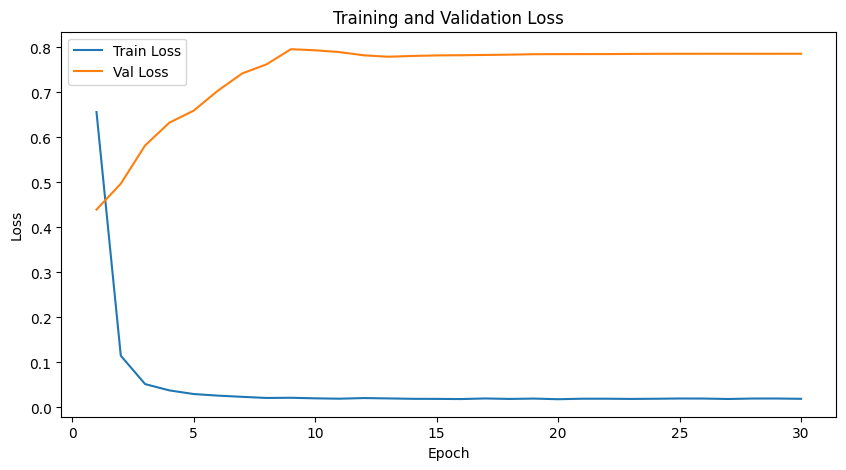

In [8]:
# Training and validation loop
num_epochs = 30
train_losses = []
val_losses = []

def train_model(classifier, train_loader, val_loader, epochs=30):
    for epoch in range(epochs):
        classifier.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = classifier(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)

        train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(train_loss)

        # Validation loop
        classifier.eval()
        val_running_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = classifier(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item() * inputs.size(0)

        val_loss = val_running_loss / len(val_loader.dataset)
        val_losses.append(val_loss)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

        # Update learning rate
        scheduler.step(val_loss)

train_model(classifier, train_loader, val_loader, epochs=num_epochs)

# Plot training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

#### 3.1. Save and Load the Model

In [9]:
# Save the model
torch.save(classifier.state_dict(), "vit_classifier.pth")

# Load the model
classifier.load_state_dict(torch.load("vit_classifier.pth"))

# Evaluate the model
# classifier.eval()

C:\Users\Stefan\AppData\Local\Temp\ipykernel_36036\1813939000.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  classifier.load_state_dict(torch.load("vit_classifier.pth")

<All keys matched successfully>

### 4. Evaluation

#### 4.1. Utility Function for Prediction

In [17]:
# Evaluate Model
def predict_model(classifier, dataloader: DataLoader, class_names):
    """
    Predict model on a given dataloader
    :param classifier:
    :param dataloader:
    :param class_names:
    :return:
    """
    classifier.eval()
    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = classifier(inputs)

            # Get probabilities and predictions
            probs = torch.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    return np.array(all_preds), np.array(all_labels), np.array(all_probs)

#### 4.2. Utility Function for Generating Confusion Matrix and Classification Report

In [19]:
def generate_confusion_matrix(labels, preds, class_names):
    """
    Generate and plot confusion matrix
    :param labels:
    :param preds:
    :param class_names:
    :return:
    """
    # Create Confusion Matrix
    cm = confusion_matrix(labels, preds, labels=range(len(class_names)))

    # Plot Confusion Matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
    plt.title("Confusion Matrix")
    plt.axis("off")
    plt.show()

def generate_classification_report(labels, preds, class_names):
    # Generate Classification Report
    report = classification_report(labels, preds, target_names=class_names)
    print(report)

#### 4.3. Utility Function for Evaluation

In [20]:
# Wrapper function to evaluate model
def evaluate_model(classifier, dataloader, class_names):
    preds, labels, probs = predict_model(classifier, dataloader, class_names)
    generate_confusion_matrix(labels, preds, class_names)
    generate_classification_report(labels, preds, class_names)
    return preds, labels, probs

#### 4.4. Utility Function for Plotting Random Samples

In [21]:
# Plot Random Samples
def plot_random_samples(dataset, preds, labels, probs, class_names, num_samples=5):
    num_samples = min(num_samples, len(dataset))

    # Randomly select indices
    random_indices = random.sample(range(len(dataset)), num_samples)

    # Calculate number of rows needed
    num_cols = 4
    num_rows = (num_samples + num_cols - 1) // num_cols

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 3 * num_rows))
    axes = axes.flatten()

    for i, idx in enumerate(random_indices):
        image, true_label = dataset[idx]
        image = (image * 0.5 + 0.5)  # Unnormalize
        image = np.clip(image, 0, 1)
        pred_label = preds[idx]
        prob = probs[idx, pred_label]  # Probability of predicted class

        axes[i].imshow(image.permute(1, 2, 0))  # Convert CHW to HWC for plotting
        axes[i].axis("off")
        axes[i].set_title(
            f"True: {class_names[true_label]}\n"
            f"Pred: {class_names[pred_label]} ({prob:.2f})"
        )

    # Hide any remaining empty subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis("off")

    plt.tight_layout()
    plt.show()

#### 4.1. Evaluate Model on train dataset

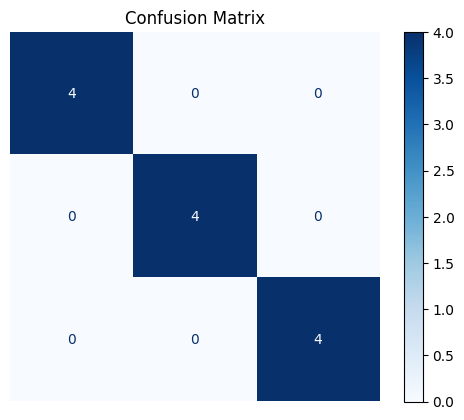

                precision    recall  f1-score   support

     1_cumulus       1.00      1.00      1.00         4
    4_clearsky       1.00      1.00      1.00         4
6_cumulonimbus       1.00      1.00      1.00         4

      accuracy                           1.00        12
     macro avg       1.00      1.00      1.00        12
  weighted avg       1.00      1.00      1.00        12



(array([0, 2, 2, 0, 0, 1, 1, 0, 1, 2, 1, 2]),
 array([0, 2, 2, 0, 0, 1, 1, 0, 1, 2, 1, 2]),
 array([[0.9810937 , 0.00954009, 0.00936624],
        [0.00884471, 0.00870773, 0.98244756],
        [0.008826  , 0.00836093, 0.98281306],
        [0.9812168 , 0.00962375, 0.00915949],
        [0.9812796 , 0.00935509, 0.00936537],
        [0.00925223, 0.98127294, 0.00947484],
        [0.00845489, 0.98135114, 0.01019401],
        [0.98109835, 0.00950791, 0.00939373],
        [0.00914064, 0.98193914, 0.00892026],
        [0.00827041, 0.00883204, 0.9828976 ],
        [0.00960985, 0.9818094 , 0.00858079],
        [0.00820453, 0.00898901, 0.98280644]], dtype=float32))

In [22]:
# Evaluate Model on train dataset
evaluate_model(classifier, train_loader, class_names)

#### 4.2. Evaluate Model on test dataset

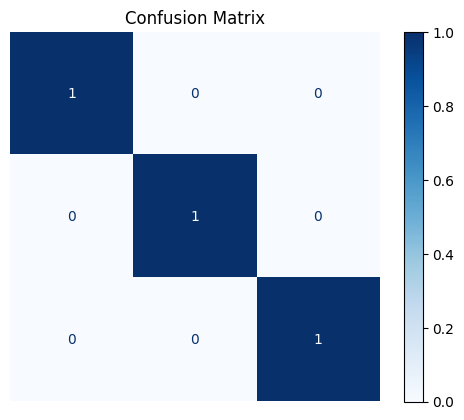

                precision    recall  f1-score   support

     1_cumulus       1.00      1.00      1.00         1
    4_clearsky       1.00      1.00      1.00         1
6_cumulonimbus       1.00      1.00      1.00         1

      accuracy                           1.00         3
     macro avg       1.00      1.00      1.00         3
  weighted avg       1.00      1.00      1.00         3



In [25]:
# Evaluate Model on test dataset
preds, labels, probs = evaluate_model(classifier, test_loader, class_names)

#### 4.3. Plot Random Samples for test dataset

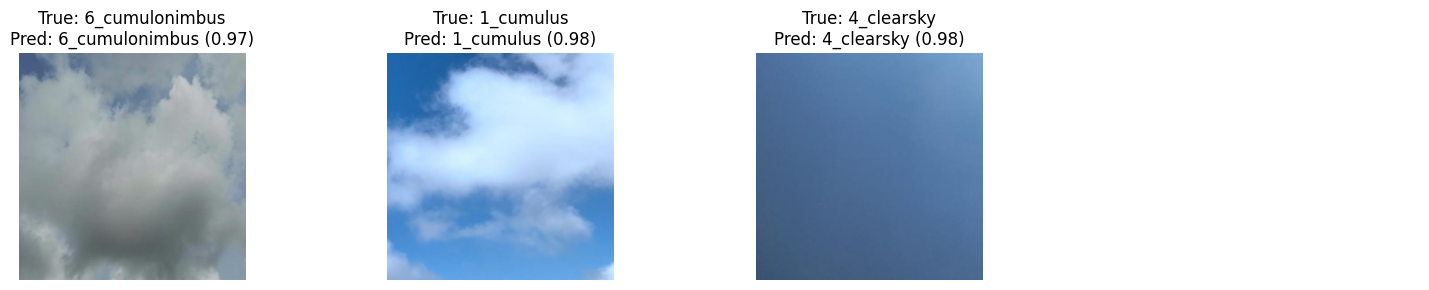

In [24]:
# Plot random samples
plot_random_samples(test_dataset, preds, labels, probs, class_names, num_samples=15)